# Основы программирования в Python
## Итоговый проект
### Копылов Валентин (БПТ171)
#### 27 декабря 2018

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from time import sleep
import datetime
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import squarify
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def lenta(url_lenta):
    """
    Парсит частоту употребелния слов на Ленте.ру по выбираемой рубрике за определенный отрезок времени
    Вход: url_lenta (str) -- url адрес ленты ру
    Выход: words_dict (dict) -- словарь частотности слов, где ключ -- слово, значение -- частота
    """
    page = requests.get(url_lenta)
    soup = BeautifulSoup(page.text, 'lxml')
    
    
    # Задаем союзы, местоимения, которые встречаются наиболее части и не несут смысловой нагрузки
    stopwords = set(STOPWORDS) # заданный список с английскими аналогами
    stopwords.update(["это", "что", "на", "быть", "из", "не", "по", "который", "то", "от", "же", "тот", "за", "до", "для", "так", "этот", "под", "в", "и", "с", "о", "он", "она"])
    
    full_url_rubrics = [] # сайты рубрик
    rubric_name = [] # названия присутствующих рубрик

    for link in soup.find_all('a')[0:15]: #все ссылки на рубрики находятся в начале, поэтому я взял примерные значения
        if '/rubrics' in link.get('href'): # + после определенного прохода цикла, там появляется величина NoneType, с которой приходится разбираться
            full_url_rubrics.append('https://lenta.ru' + link.get('href'))
            rubric_name.append(link.text)
    
    # Создаем словарь рубрик с их адресами 
    rubrics_dict = {}

    for i in range(len(rubric_name)):
        rubrics_dict[rubric_name[i]] = full_url_rubrics[i]
    
    
    # Пользователь указывает интересующий временной отрезок
    date1 = input('Введите начало временного отрезка: ').split(' ') 
    start_date = datetime.date(year = int(date1[2]), month = int(date1[1]), day = int(date1[0]))

    date2 = input('Введите конец временного отрезка: ').split(' ') 
    end_date = datetime.date(year = int(date2[2]), month = int(date2[1]), day = int(date2[0]))
    # количество прогона цикла (+1)
    diff_date = (end_date - start_date).days
    
    # Выводим имеющиеся рубрики для более удобного выбора
    print(rubric_name)
    
    # Создаем частотный словарь
    words_dict = {}
    
    count_words_within_days_andrubric(words_dict, input('Введите название рубрики: '), start_date, diff_date, rubrics_dict)
    
    return words_dict

In [3]:
def count_words_within_days_andrubric(dictionary, rubric, start_date, diff_date, rubrics_dict):
    """
     Функция, считающая слова в рубрике за определенный отрезок времени.
     Вход: dictionary (dict) -- создаваемый частотный словарь, rubric (str) -- обрабатываемая рубрика, 
           start_date (datetime) -- начальная дата отсчета, diff_date (int) -- дней между рассматриваемым отрезком времени, 
           rubrics_dict (dict) -- словарь с url рубрик
     Выход: dictionary (dict) -- создаваемый частотный словарь
    """
    start = start_date
    for i in range(diff_date + 1): 
        # определенный паттерн даты в url
        url_date = str(start.year) + '/' + str(start.month // 10) + str(start.month % 10) + '/' + str(start.day // 10) + str(start.day % 10)
        count_in_dict_rubr(getrubric(rubrics_dict[rubric] + url_date, url_date), dictionary)
        # следующий день
        start += datetime.timedelta(days = 1)
    return dictionary

In [4]:
def getrubric(rubric, date_url): # выводит слова в рубрике 
    """
    Выводит слова в рубрике за один день
    Вход: rubric (str) -- url адрес рассматриваемой рубрики, date_url (str) -- часть url, связанная с временем
    Выход: smth (tuple) -- кортеж всех значений получаемых из следующей функции (title, date, text)
    """
    
    url0 = rubric
    page0 = requests.get(url0)
    soup0 = BeautifulSoup(page0.text, 'lxml')
    
    buf = '/news/' + date_url # изменяющаяся часть адреса, которая вынесена в отдельную переменную для удобства
    
    
    # создаем список сайтов, которые будем парсить в дальнейшем
    half_sites = []

    for link in soup0.find_all('a'):
        if link.get('href') is not None and buf in link.get('href'):
            half_sites.append(link.get('href'))
            
    sites = []
    for u in half_sites:
        sites.append('https://lenta.ru' + u)
        
    # парсим информацию с страниц
    smth = []
    for i in sites: 
        smth.append(getnews(i))
        # чтобы не заблокировали
        sleep(1)
        
    return smth

In [5]:
def getnews(news): # парсит новость
    """
    Функция парсит новость и вытаскивает из нее название, дату(не используется далее) и сам текст
    Вход: news (str) -- url статьи, из который вытаскиваем данные
    Выход: title (str) -- название статьи, date (str) -- время написания, text(str) -- текст статьи
    """
    url00 = news
    page00 = requests.get(url00)
    soup00 = BeautifulSoup(page00.text, 'lxml')
    
    # заголовок и дата
    title = soup00.find_all('h1')[0].text
    date = soup00.find_all('div', {'class' : 'b-topic__info'})[0].text.strip().split(', ')
    
    text = ''
    # вытаскиваем тело статьи по данному тегу
    for i in soup00.find_all('p'):
        text += i.text
        
    return title, date, text

In [6]:
def count_in_dict_rubr(rubr_list, dicti):
    """
    Функция, считающая число "отнормаленых слов" в рубрике на ленте ру
    Вход: rubr_list (tuple) -- информация, вытащенная с страниц ленты ру, 
          dicti (dict) -- создаваемый словарь частотности для отнормаленых слов
    """
    # Задаем стоп-слова, которые не будут нас интересовать
    stopwords = set(STOPWORDS)
    stopwords.update(["это", "что", "на", "быть", "из", "не", "по", "который", "то", "от", "же", "тот", "за", "до", "для", "так", "этот", "под", "в", "и", "с", "о", "он", "она"])
    
    for i in rubr_list: 
        # соединяем заголовок с основным текстов
        a = i[0] + ' ' + i[2]
        a = a.replace('\xa0', ' ').lower() # избавляемся от мусора

        b = re.findall('\w+', a) # вытаскиваем слова состоящие из букв и цифр в отдельный список

        
        # выставляем слова в нормальную форму для более удобного взаимодействия
        for j in b:
            if  morph.parse(j)[0].normal_form in dicti.keys() and morph.parse(j)[0].normal_form not in stopwords:
                dicti[morph.parse(j)[0].normal_form] += 1
            else: 
                dicti[morph.parse(j)[0].normal_form] = 1
    

In [15]:
def newsru (url_newsru):
    """
    Парсит частоту употребелния слов на newsru.com по выбираемой рубрике за определенный отрезок времени
    Вход: url_newsru (str) -- url адрес ленты ру
    Выход: dict_newsru (dict) -- словарь частотности слов, где ключ -- слово, значение -- частота
    """
    
    page = requests.get(url_newsru)
    soup = BeautifulSoup(page.text, 'lxml')
    
    url_rubric = []
    name_rubric = []

    for link in soup.find_all('a', {'class': 'menu'})[1:8]:
        url_rubric.append('http://' + link.get('href')[2:])
        name_rubric.append(link.text)

    #Создадим словарь рубрик с url ссылками
    rubrics_dict = {}

    for i in range(len(name_rubric)):
        rubrics_dict[name_rubric[i]] = url_rubric[i]

        
    # задаем временной отрезок
    date1 = input('Введите начало: ').split(' ') 
    start_date = datetime.date(year = int(date1[2]), month = int(date1[1]), day = int(date1[0]))

    date2 = input('Введите конец: ').split(' ') 
    end_date = datetime.date(year = int(date2[2]), month = int(date2[1]), day = int(date2[0]))
    
    diff_date = (end_date - start_date).days
    # выводим названия рубрик, для более удобного выбора
    print(name_rubric)
    
    dict_newsru = {}
    # выбираем рубрику
    count_words_within_days_newsru(dict_newsru, input('Введите название рубрики: '), rubrics_dict, start_date, diff_date)
    return dict_newsru

In [16]:
def parse_news_newsru(site_to_parse): 
    """
    Функция парсит новость и вытаскивает из нее название, дату(не используется далее) и сам текст
    Вход: site_to_parse (str) -- url статьи, из который вытаскиваем данные
    Выход: title (str) -- название статьи, time (str) -- время написания, text(str) -- текст статьи
    """
    page = requests.get(site_to_parse)
    soup = BeautifulSoup(page.text, 'lxml')
    
    title = soup.find('h1').text.replace('\n', '').replace('\t', '').lower() # заголовок
    
    time = soup.find('div', {'class':'article-date'}).text.replace('\n', '').replace('\t', '').lower() # время
    # парсим текст статьи
    article = ''
    for i in soup.find_all('p'):
        article += i.text
    # приводим слова к единообразному виду
    article = article.replace('\r\n', ' ').lower() 
    
    return title, time, article

In [17]:
def getrubric_newru(rubric_url, date, start_date):
    """
    Выводит слова в рубрике за один день
    Вход: rubric_url (str) -- url адрес рассматриваемой рубрики, date (str) -- часть url, связанная с временем, 
          start_date (datetime) -- необходим для поиска нужного паттерна в html коде
    Выход: smth (tuple) -- кортеж всех значений получаемых из следующей функции (title, date, text)
    """
    page = requests.get(rubric_url + date)
    soup = BeautifulSoup(page.text, 'lxml')
    
    
    sites_url = []
    for link in soup.find_all('div', {'class':'index-news-content'}):
        if (str(start_date.day) + ' ') in link.find('span').text: # добавил ' ' для защиты от времени 21:28
            sites_url.append('http://www.newsru.com' + link.find('a', {'class':'index-news-title'}).get('href'))
      
    # создаем общий список для искомых величин
    smth = []
    for i in sites_url: 
        sleep(1)
        smth.append(parse_news_newsru(i))
    
    return smth

In [7]:
def mood_mean():
    """
    Данная функция создает словарь тональностей и берет средние значения по каждому слова для дальнейшего применения
    Выход: dict_of_mood_mean (dict) -- словарь средних тональностей
    """
    df = pd.read_excel('full_word_rating_after_coding.xlsx', names=['слова', 'тональность'], header=None, dtype={'0':str, '1':int})
    # нас интересуют средние значения по словам
    df = df.groupby('слова').agg('mean')
    
    ton = []
    for i in range(len(df)):
        ton.append(df.iloc[i,][0])
    
    dict_of_mood_mean = {}
    for i in range(len(list(df.index))):
        dict_of_mood_mean[list(df.index)[i]] = ton[i]
    
    return dict_of_mood_mean
    

In [18]:
def count_in_dict_rubr_newsru(rubr_list, dicti):
    """
    Функция, считающая число "отнормаленых слов" в рубрике на newsru
    Вход: rubr_list (tuple) -- информация, вытащенная с страниц newsru, 
          dicti (dict) -- создаваемый словарь частотности для отнормаленых слов
    """
    # задаем стоп слова
    stopwords = set(STOPWORDS)
    stopwords.update(["это", "что", "на", "быть", "из", "не", "по", "который", "то", "от", "же", "тот", "за", "до", "для", "так", "этот", "под", "в", "и", "с", "о", "он", "она"])
    
    for i in rubr_list: 
        a = i[0] + ' ' + i[2]
        b = re.findall('\w+', a)
    # нормалим слова и делаем словарь из этих значений
        for j in b:
            if  morph.parse(j)[0].normal_form in dicti.keys() and morph.parse(j)[0].normal_form not in stopwords:
                dicti[morph.parse(j)[0].normal_form] += 1
            else: 
                dicti[morph.parse(j)[0].normal_form] = 1

In [19]:
def count_words_within_days_newsru(dictionary, rubric, rubrics_dict, start_date, diff_date): 
    """
     Функция, считающая слова в рубрике за определенный отрезок времени.
     Вход: dictionary (dict) -- создаваемый частотный словарь, rubric (str) -- обрабатываемая рубрика, 
           start_date (datetime) -- начальная дата отсчета, diff_date (int) -- дней между рассматриваемым отрезком времени, 
     Выход: dictionary (dict) -- создаваемый частотный словарь
    """
    
    # создаем словарь месяцев для удобного взаимодействия с url
    month_newsru = {
    1: 'jan',
    2: 'feb',
    3: 'mar',
    4: 'apr',
    5: 'may',
    6: 'jun',
    7: 'jul',
    8: 'aug',
    9: 'sep',
    10: 'oct',
    11: 'nov',
    12: 'dec'
    }
    # создаем словарь
    start = start_date 
    for i in range(diff_date + 1):
        # определенный паттерн времени в url
        url_date = str(start.day // 10) + str(start.day % 10) + month_newsru[start.month] + str(start.year)
        count_in_dict_rubr_newsru(getrubric_newru(rubrics_dict[rubric], url_date, start), dictionary)
        start += datetime.timedelta(days = 1)
    return dictionary

In [8]:
def mood():
    """
    Данная функция создает словарь тональностей и берет максимальные или минимальные (в зависимости от направленности слова)
    значения по каждому слова для дальнейшего применения
    Выход: dict_of_mood (dict) -- словарь средних тональностей
    """
    df = pd.read_excel('full_word_rating_after_coding.xlsx', names=['слова', 'тональность'], header=None, dtype={'0':str, '1':int})
    # нас интересует максимальная и минимальная тональность
    df = df.groupby('слова').agg(['max', 'min'])
    ton = []
    for i in range(len(new_df)):
        if new_df.iloc[i,][0] > 0:
            ton.append(new_df.iloc[i,][0])
        elif new_df.iloc[i,][1] < 0:
            ton.append(new_df.iloc[i,][1])
        else:
            ton.append(0)
    df['итог'] = ton 
    # создаем словарь
    dict_of_mood = {}
    for i in range(len(list(new_df.index))):
        dict_of_mood[list(new_df.index)[i]] = list(new_df['итог'])[i]
    
    return dict_of_mood

In [9]:
def df_text_anal(temp, dict_of_mood):
    """
    Данная функция создает предметы для дальнейшем визуализации
    Вход: temp (dict) -- частотный словарь отнормаленных слов, dict_of_mood (dict) -- словарь средних тональностей
    Выход: df (pandas.DataFrame) -- датафрейм с нужными нам характеристиками частотности и тональности,
           whole_text (str) -- вновь собранный текст для погружения в облако слов
    """
    new_temp = {}
    for i in list(temp.keys()):
        if i in dict_of_mood:
            new_temp[i] = [temp[i], dict_of_mood[i]]
        else:
            new_temp[i] = [temp[i], -99] # в словаре тональностей только существительные (много пропущенных значений)
            
    df = pd.DataFrame.from_dict(new_temp, orient='index', columns=['Частота', 'Тональность'])
    
    whole_text = ''
    for key, value in temp.items():
        for i in range(value):
            whole_text += (key + ' ')
            
    return df, whole_text

In [10]:
def wordcloud_words(stopwords, temporary, dict_of_mood_mean):
    """
    Данная функция создает облако слов
    Вход: stopwords (list) -- стоп-слова, temporary (str) -- информация, которую мы визуализируем, 
          dict_of_mood (dict) -- словарь средних тональностей
    Выход: облако слов
    """
    stopwords = set(STOPWORDS)
    stopwords.update(["это", "что", "на", "быть", "из", "не", "по", "который", "то", "от", "же", "тот", "за", "до", "для", "так", "этот", "под", "в", "и", "с", "о", "он", "она"])

    # Generate a word cloud image
    mask = np.array(Image.open("russia.png"))
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=100, mask=mask, collocations=False).generate(df_text_anal(temporary, dict_of_mood_mean)[1])

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    plt.show()

In [11]:
def barchart_words(temp, dict_of_mood_mean):
    """
    Данная функция создает столбчатую диаграмму
    Вход: temp (pandas.DataFrame) -- датафрейм с тональностями и частотностью, 
          dict_of_mood_mean (dict) -- словарь средних тональностей (можно поменять на словарик с max и min)
    Выход: столбчатая диаграмма
    """
    new_df = df_text_anal(temp, dict_of_mood_mean)[0].sort_values(by='Частота', ascending=False)[0:20]

    objects = list(new_df.index)
    y_pos = np.arange(len(objects))
    performance = list(new_df["Частота"])

    plt.barh(y_pos, performance, align='center', alpha=0.6, color='r')
    plt.yticks(y_pos, objects)
    plt.xlabel('Частота')
    plt.title('Самые часто встречающиеся слова')
    plt.show()

In [12]:
def hist_words_mood(temp, dict_of_mood_mean):
    """
    Данная функция создает тональную гистограмму
    Вход: temp (pandas.DataFrame) -- датафрейм с тональностями и частотностью, 
          dict_of_mood_mean (dict) -- словарь средних тональностей (можно поменять на словарик с max и min)
    Выход: тональная гистограмма 
    """
    
    df1 = df_text_anal(temp, dict_of_mood_mean)[0].sort_values(by='Тональность', ascending=False).groupby('Тональность').agg('sum')
    df1 = df1.iloc[1:,:] # чтобы избавится от пропущенных значений
    
    # создаем "выборку" из которой будем строить гистограмму
    x_1 = []
    for i in range(len(list(df1.index))):
        for j in range(int(df1.iloc[i,])):
            x_1.append(list(df1.index)[i])
            
    
    x = x_1
    num_bins = len(df1)
    n, bins, patches = plt.hist(x, num_bins, facecolor='green', alpha=0.9)
    plt.show()

In [13]:
def tree_word_freq(temp, dict_of_mood):
    """
    Данная функция создает дерево слов с частотностью
    Вход: temp (pandas.DataFrame) -- датафрейм с тональностями и частотностью, 
          dict_of_mood_mean (dict) -- словарь средних тональностей (можно поменять на словарик с max и min)
    Выход: Дерево слов с частотностью
    """
    
    df99 = df_text_anal(temp, dict_of_mood)[0].sort_values(by='Частота', ascending=False)
    df99 = df99[df99['Тональность'] != -99][:50]
    
    norm = matplotlib.colors.Normalize(vmin=df99['Частота'].min(), vmax=df99['Частота'].max())
    df99['color'] = df99['Частота'].apply(lambda x: matplotlib.cm.Blues(norm(x)))

    squarify.plot(sizes=df99['Частота'], label=df99.index, alpha=.7, norm_x=100, norm_y=100, color=df99.color)

    fig = plt.gcf()
    ax = fig.add_subplot()
    fig.set_size_inches(16, 4.5)

    plt.title("Дерево слов",fontsize=23,fontweight="bold")
    plt.axis('off')
    plt.show() 

In [14]:
def tree_word_mood(temp, dict_of_mood):
    """
    Данная функция создает Дерево слов с тональностью
    Вход: temp (pandas.DataFrame) -- датафрейм с тональностями и частотностью, 
          dict_of_mood_mean (dict) -- словарь средних тональностей (можно поменять на словарик с max и min)
    Выход: Дерево слов с тональностью 
    """
    df99 = df_text_anal(temp, dict_of_mood)[0].sort_values(by='Частота', ascending=False)
    df99 = df99[df99['Тональность'] != -99][:50]
    
    norm = matplotlib.colors.Normalize(vmin=df99['Тональность'].min(), vmax=df99['Тональность'].max())
    df99['color'] = df99['Тональность'].apply(lambda x: matplotlib.cm.Blues(norm(x)))

    squarify.plot(sizes=df99['Частота'], label=df99.index, alpha=.7, norm_x=100, norm_y=100, color=df99.color)

    fig = plt.gcf()
    ax = fig.add_subplot()
    fig.set_size_inches(16, 4.5)

    plt.title("Дерево слов",fontsize=23,fontweight="bold")
    plt.axis('off')
    plt.show()

In [20]:
def main():
    """
    Основная функция, проигрывающая код посредством взаимодействия с пользователем
    """
    
    news_sources_dict = {
    'Lenta': 'https://lenta.ru', 
    'newsru':'https://www.newsru.com',
    }
    
    news_sources_names = list(news_sources_dict.keys())
    
    print (news_sources_names)
    dict_of_mood_mean = mood_mean()
    name_of_visual = ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
    
    stopwords = set(STOPWORDS)
    stopwords.update(["это", "что", "на", "быть", "из", "не", "по", "который", "то", "от", "же", "тот", "за", "до", "для", "так", "этот", "под", "в", "и", "с", "о", "он", "она"])
    
    resource = input('Введите название ресурса, которое вы хотите рассмотреть: ')
    
    if resource == 'Lenta': 
        temp = lenta(news_sources_dict['Lenta'])
    elif resource == 'newsru':
        temp = newsru(news_sources_dict['newsru'])

    i = 0
    while i < 5:
        print('Возможные визуализации:', name_of_visual)
        inp = input('Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось %s попыток...) '%(5 - i))
        if inp == name_of_visual[0]: 
            wordcloud_words(stopwords, temp, dict_of_mood_mean)
            i += 1
        elif inp == name_of_visual[1]:
            barchart_words(temp, dict_of_mood_mean)
            i += 1
        elif inp == name_of_visual[2]:
            hist_words_mood(temp, dict_of_mood_mean)
            i += 1
        elif inp == name_of_visual[3]:
            tree_word_mood(temp, dict_of_mood_mean)
            i += 1
        elif inp == name_of_visual[4]:
            tree_word_freq(temp, dict_of_mood_mean)
            i += 1
        else:
            break


['Lenta', 'newsru']
Введите название ресурса, которое вы хотите рассмотреть: newsru
Введите начало: 12 12 2018
Введите конец: 13 12 2018
['В РОССИИ', 'В МИРЕ', 'ЭКОНОМИКА', 'РЕЛИГИЯ', 'КРИМИНАЛ', 'СПОРТ', 'КУЛЬТУРА']
Введите название рубрики: РЕЛИГИЯ
Возможные визуализации: ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось 5 попыток...) Облако слов


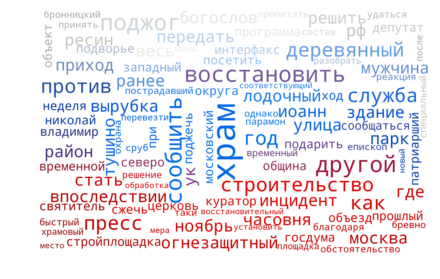

Возможные визуализации: ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось 4 попыток...) Столбчатая диаграмма


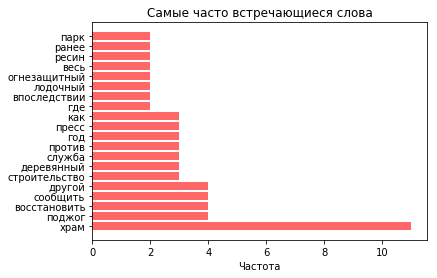

Возможные визуализации: ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось 3 попыток...) Тональная гистограмма


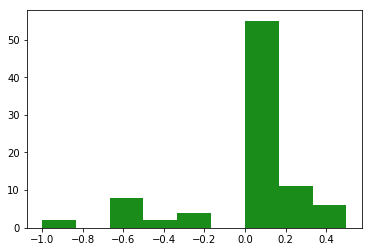

Возможные визуализации: ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось 2 попыток...) Дерево слов с тональностью


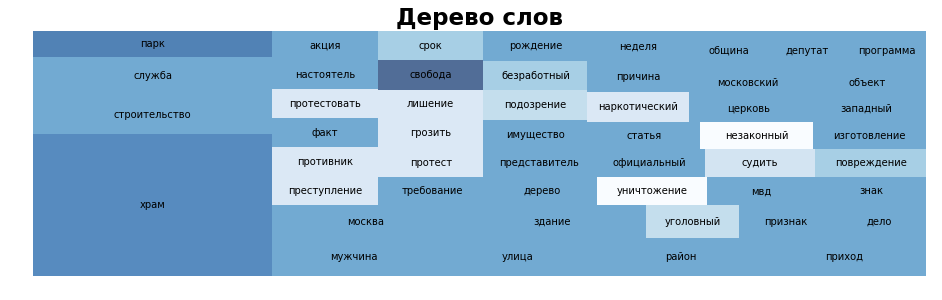

Возможные визуализации: ['Облако слов', 'Столбчатая диаграмма', 'Тональная гистограмма', 'Дерево слов с тональностью', 'Дерево слов с частотностью']
Какую визуализацию вы хотели посмотреть? (Вводите осторожно, осталось 1 попыток...) Дерево слов с частотностью


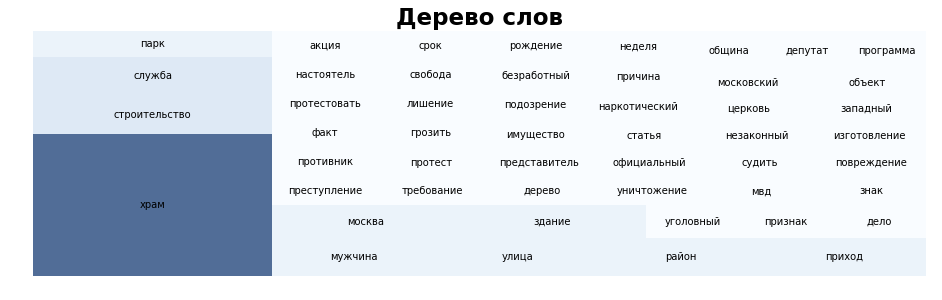

In [22]:
# основное место взаимодействия
main() 